In [136]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [137]:
data = pd.read_csv(
    "data/round4/prices_round_4_day_2.csv",
    sep = ';'
)

In [138]:
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,2,0,PEARLS,9998.0,3.0,9996.0,1.0,9995.0,21.0,10004.0,1.0,10005.0,21.0,NaN,NaN,10001.0,0.0
1,2,0,BANANAS,4822.0,3.0,4821.0,22.0,NaN,NaN,4827.0,22.0,NaN,NaN,NaN,NaN,4824.5,0.0
2,2,0,DIVING_GEAR,99191.0,20.0,NaN,NaN,NaN,NaN,99194.0,20.0,NaN,NaN,NaN,NaN,99192.5,0.0
3,2,0,COCONUTS,7923.0,214.0,NaN,NaN,NaN,NaN,7925.0,64.0,7926.0,150.0,NaN,NaN,7924.0,0.0
4,2,0,DIP,7094.0,59.0,7093.0,196.0,NaN,NaN,7095.0,59.0,7096.0,196.0,NaN,NaN,7094.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,2,999900,PICNIC_BASKET,74008.0,1.0,74007.0,19.0,74006.0,20.0,74019.0,1.0,74020.0,19.0,74021.0,20.0,74013.5,211296.0
109996,2,999900,DOLPHIN_SIGHTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3094.0,0.0
109997,2,999900,PINA_COLADAS,14847.0,102.0,NaN,NaN,NaN,NaN,14850.0,102.0,NaN,NaN,NaN,NaN,14848.5,32480.0
109998,2,999900,DIP,7020.0,240.0,NaN,NaN,NaN,NaN,7022.0,240.0,NaN,NaN,NaN,NaN,7021.0,487852.0


In [139]:
dip = data.query("product == 'DIP'")\
    .set_index("timestamp")
baguette = data.query("product == 'BAGUETTE'")\
    .set_index("timestamp")
ukulele = data.query("product == 'UKULELE'")\
    .set_index("timestamp")
picnic_basket = data.query("product == 'PICNIC_BASKET'")\
    .set_index("timestamp")

# Correlation 

In [140]:
basket_separated = (ukulele + 4*dip + 2*baguette) \
    .mid_price

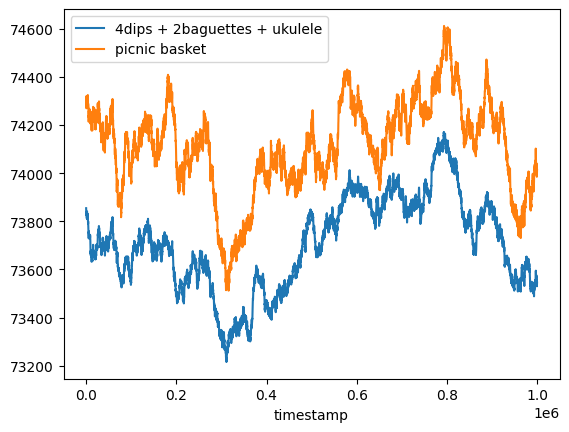

In [141]:
basket_separated.plot(
    label = '4dips + 2baguettes + ukulele'
)

picnic_basket\
    .mid_price\
    .plot(
        label = 'picnic basket'
    )

plt.legend()

In [169]:
(picnic_basket.mid_price/basket_separated)\
    .describe()

count    10000.000000
mean         1.005472
std          0.001393
min          1.001232
25%          1.004450
50%          1.005535
75%          1.006408
max          1.009591
Name: mid_price, dtype: float64

In [142]:
basket_separated.corr(
    picnic_basket.mid_price
)

0.8591620663595901

In [143]:
spread = picnic_basket.mid_price - basket_separated

<Axes: xlabel='timestamp'>

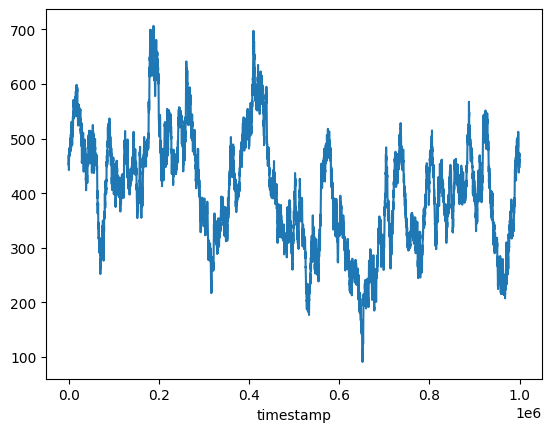

In [144]:
spread.plot()

In [145]:
window = 200

avg_rolling_spread = spread.rolling(window)\
    .mean()

mov_spread5 = spread.rolling(5).mean()

rolling_std_spread = spread.rolling(window)\
    .std()


In [146]:
zscore_spread = (mov_spread5 - avg_rolling_spread)/rolling_std_spread

<Axes: xlabel='timestamp'>

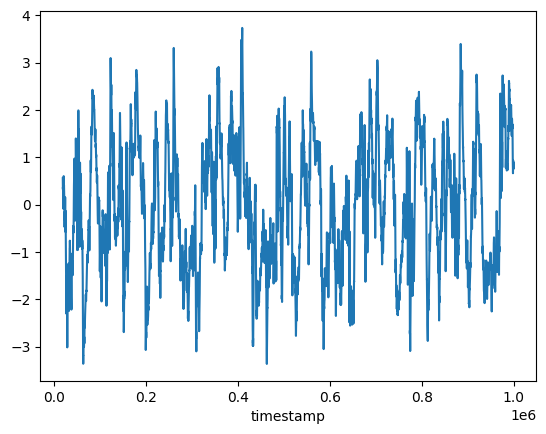

In [147]:
zscore_spread.plot()

In [148]:
buy = zscore_spread < -2
sell = zscore_spread > 2

(0.0, 1000000.0)

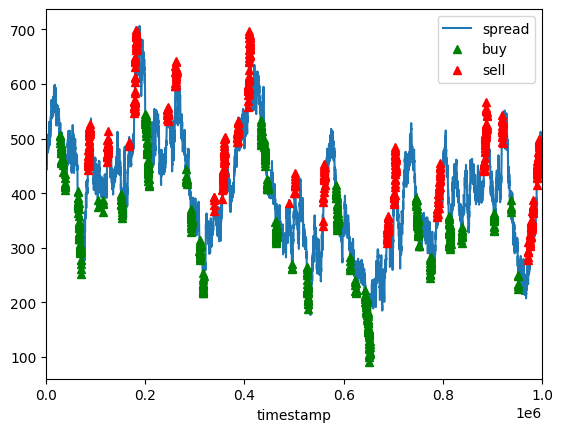

In [149]:
spread.plot(label = 'spread')
spread[buy].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
spread[sell].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.legend()
plt.xlim([0, 1e6])

In [150]:
spread[sell].shape, spread[buy].shape

((603,), (637,))

In [151]:
position_size = (spread[buy].shape[0] - spread[sell].shape[0])

In [152]:
pnl = (spread[sell].sum() - spread[buy].sum() - position_size*spread.iloc[-1])

In [153]:
cash = pd.concat([spread[sell], -spread[buy]])\
    .sort_index()\
    .cumsum()\
    .reindex(picnic_basket.index)\
    .fillna(method="ffill")

In [154]:
position = pd.Series(0, index = picnic_basket.index)

In [155]:
for idx, value in spread[sell].items():
    position.loc[idx] = -1

for idx, value in spread[buy].items():
    position.loc[idx] = 1

position = position.cumsum()

In [156]:
value_on_position = (position * spread)\
    .reindex(picnic_basket.index)\
    .fillna(method="ffill")

In [157]:
pnl = value_on_position + cash

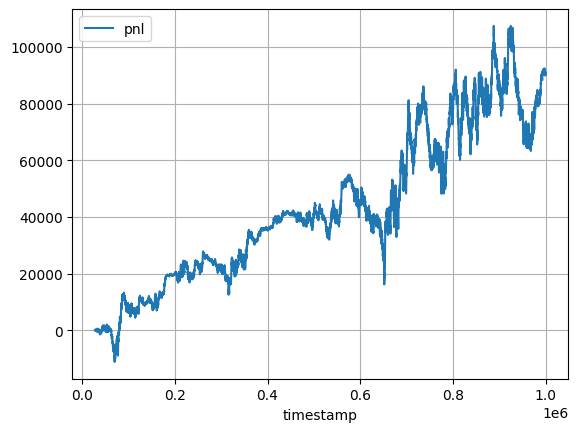

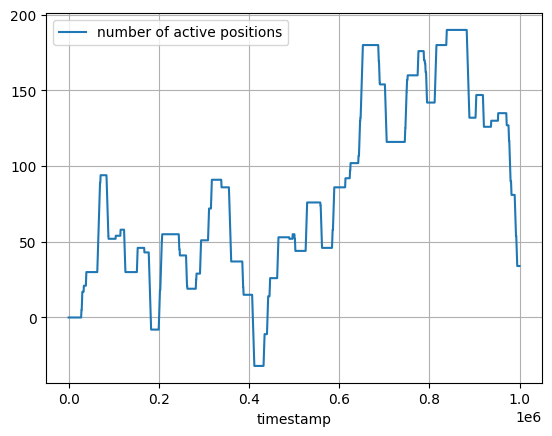

In [167]:
pnl.plot(
    label = "pnl"
)
plt.grid()
plt.legend()


plt.figure()
position.plot(
    label = "number of active positions"
)
plt.grid()
plt.legend()



In [159]:
sharpe = pnl.mean()/pnl.std()
sharpe

1.5930270256964565

# Liquidity study

In [160]:
picnic_basket_bid_mask = picnic_basket\
    .columns\
    .str\
    .contains("ask_volume")

picnic_basket[picnic_basket.columns[picnic_basket_bid_mask]]\
    .sum(axis=1)\
    .describe()

count    10000.00000
mean        37.86870
std          6.56792
min         11.00000
25%         34.00000
50%         38.00000
75%         42.00000
max         54.00000
dtype: float64

In [161]:
dip_mask = dip\
    .columns\
    .str\
    .contains("bid_volume")

dip[dip.columns[dip_mask]]\
    .sum(axis = 1)\
    .describe()

count    10000.000000
mean       225.252000
std         32.481724
min        145.000000
25%        200.000000
50%        225.000000
75%        251.000000
max        305.000000
dtype: float64

In [162]:
ukulele_mask = ukulele\
    .columns\
    .str\
    .contains("ask_volume")

ukulele[ukulele.columns[ukulele_mask]]\
    .sum(axis = 1)\
    .describe()

count    10000.000000
mean        62.484100
std          7.614706
min         45.000000
25%         57.000000
50%         63.000000
75%         68.000000
max         88.000000
dtype: float64

In [163]:
baguette_mask = baguette\
    .columns\
    .str\
    .contains("bid_volume")

baguette[baguette.columns[baguette_mask]]\
    .sum(axis =1)\
    .describe()

count    10000.000000
mean       119.870000
std         17.129852
min         72.000000
25%        107.000000
50%        120.000000
75%        133.000000
max        164.000000
dtype: float64

In [164]:
def f(x):
    x.append("hello")

In [165]:
x = []
f(x)
x

['hello']